# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Tradable Forecasting** </span><span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [122]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [41]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login(
    project = "StockPrediction",
    api_key_value = os.environ["HOPSWORKS_API_KEY"],
)
fs = project.get_feature_store() 

2025-01-06 11:56:24,457 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 11:56:24,470 INFO: Initializing external client
2025-01-06 11:56:24,472 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 11:56:26,186 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1205424


In [43]:
# Retrieve feature groups
sp_spot_fg = fs.get_feature_group(
    name='spot',
    version=1,
)

sp_googl_fg = fs.get_feature_group(
    name='googl',
    version=1,
)

sp_btc_fg = fs.get_feature_group(
    name='btc',
    version=1,
)

sp_snp_fg = fs.get_feature_group(
    name='sandp',
    version=1,
)

spot_sentim_fg = fs.get_feature_group(
    name='spotify_sentiment',
    version=1,
)

googl_sentim_fg = fs.get_feature_group(
    name='google_sentiment',
    version=1,
)

btc_sentim_fg = fs.get_feature_group(
    name='bitcoin_sentiment',
    version=1,
)

In [44]:
spot_sentim_df = spot_sentim_fg.read()
spot_sentim_df.info()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype                  
---  ------                   --------------  -----                  
 0   timestamp                1689 non-null   datetime64[us, Etc/UTC]
 1   overall_sentiment_score  1689 non-null   float64                
dtypes: datetime64[us, Etc/UTC](1), float64(1)
memory usage: 26.5 KB


--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [53]:
# Select features and labels for the model
# We create 3 models for each stock and therefore 3 feature views

# Spotify
spot_query = sp_spot_fg.select_all()\
    .join(spot_sentim_fg.select(['timestamp', 'overall_sentiment_score']), on=['timestamp'], prefix="sentim_")\
    .join(sp_snp_fg.select(['timestamp', 'price']), on=['timestamp'], prefix="snp_")\
    

# Google
googl_query = sp_googl_fg.select_all()\
    .join(googl_sentim_fg.select(['timestamp', 'overall_sentiment_score']), on=['timestamp'], prefix="sentim_")\
    .join(sp_snp_fg.select(['timestamp', 'price']), on=['timestamp'], prefix="snp_")

# BTC
btc_query = sp_btc_fg.select_all()\
    .join(btc_sentim_fg.select(['timestamp', 'overall_sentiment_score']), on=['timestamp'], prefix="sentim_")\
    .join(sp_snp_fg.select(['timestamp', 'price']), on=['timestamp'], prefix="snp_")

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [188]:
spotify_fv = fs.get_or_create_feature_view(
    name='spotify_feature_view',
    description="Basis for the training data for spotify stock prediction",
    version=1,
    labels=['price'],
    query=spot_query,
)

google_fv = fs.get_or_create_feature_view(
    name='google_feature_view',
    description="Basis for the training data for google stock prediction",
    version=1,
    labels=['price'],
    query=googl_query,
)

btc_fv = fs.get_or_create_feature_view(
    name='btc_feature_view',
    description="Basis for the training data for bitcoin stock prediction",
    version=1,
    labels=['price'],
    query=btc_query,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [189]:
# Check the schema of each feature group
for feature_group in [sp_spot_fg, sp_googl_fg, sp_btc_fg]:  # Replace with your actual feature groups
    print(feature_group.schema)


[Feature('timestamp', 'timestamp', 'Day of data', True, False, None, None, 1393604), Feature('price', 'double', 'closing price', False, False, None, None, 1393604)]
[Feature('timestamp', 'timestamp', 'Day of data', True, False, None, None, 1394635), Feature('price', 'double', 'closing price', False, False, None, None, 1394635)]
[Feature('timestamp', 'timestamp', 'Day of data', True, False, None, None, 1394636), Feature('price', 'double', 'closing price', False, False, None, None, 1394636)]


In [190]:
spot_x_train, spot_x_test, spot_y_train, spot_y_test = spotify_fv.train_test_split(test_size=0.2,)

googl_x_train, googl_x_test, googl_y_train, googl_y_test = google_fv.train_test_split(test_size=0.2,)

btc_x_train, btc_x_test, btc_y_train, btc_y_test = btc_fv.train_test_split(test_size=0.2,)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 


In [191]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

spot_train_features = spot_x_train.drop(['timestamp','sentim_timestamp', 'snp_timestamp'], axis=1)
spot_test_features = spot_x_test.drop(['timestamp','sentim_timestamp', 'snp_timestamp'], axis=1)

googl_train_features = googl_x_train.drop(['timestamp','sentim_timestamp', 'snp_timestamp'], axis=1)
googl_test_features = googl_x_test.drop(['timestamp','sentim_timestamp', 'snp_timestamp'], axis=1)

btc_train_features = btc_x_train.drop(['timestamp','sentim_timestamp', 'snp_timestamp'], axis=1)
btc_test_features = btc_x_test.drop(['timestamp','sentim_timestamp', 'snp_timestamp'], axis=1)

In [192]:
# Spotify
spot_train_features = spot_train_features.dropna()
spot_y_train = spot_y_train.loc[spot_train_features.index]

spot_test_features = spot_test_features.dropna()
spot_y_test = spot_y_test.loc[spot_test_features.index]

# Google
googl_train_features = googl_train_features.dropna()
googl_y_train = googl_y_train.loc[googl_train_features.index]

googl_test_features = googl_test_features.dropna()
googl_y_test = googl_y_test.loc[googl_test_features.index]

# BTC
btc_train_features = btc_train_features.dropna()
btc_y_train = btc_y_train.loc[btc_train_features.index]

btc_test_features = btc_test_features.dropna()
btc_y_test = btc_y_test.loc[btc_test_features.index]

In [193]:
# Initialize the MinMaxScaler
spot_scaler = MinMaxScaler()
googl_scaler = MinMaxScaler()
btc_scaler = MinMaxScaler() 

# Normalize the price values in the y_train dataframe for Spotify, Google, and BTC
spot_y_train['price'] = spot_scaler.fit_transform(spot_y_train[['price']])
googl_y_train['price'] = googl_scaler.fit_transform(googl_y_train[['price']])
btc_y_train['price'] = btc_scaler.fit_transform(btc_y_train[['price']])

# Normalize the price values in the y_test dataframe for Spotify, Google, and BTC
spot_y_test['price'] = spot_scaler.transform(spot_y_test[['price']])
googl_y_test['price'] = googl_scaler.transform(googl_y_test[['price']])
btc_y_test['price'] = btc_scaler.transform(btc_y_test[['price']])

# Normalize the snp_price in the train and test features for Spotify, Google, and BTC
spot_train_features['snp_price'] = spot_scaler.fit_transform(spot_train_features[['snp_price']])
spot_test_features['snp_price'] = spot_scaler.transform(spot_test_features[['snp_price']])

googl_train_features['snp_price'] = googl_scaler.fit_transform(googl_train_features[['snp_price']])
googl_test_features['snp_price'] = googl_scaler.transform(googl_test_features[['snp_price']])

btc_train_features['snp_price'] = btc_scaler.fit_transform(btc_train_features[['snp_price']])
btc_test_features['snp_price'] = btc_scaler.transform(btc_test_features[['snp_price']])

spot_min = spot_scaler.data_min_
spot_max = spot_scaler.data_max_

googl_min = googl_scaler.data_min_
googl_max = googl_scaler.data_max_

btc_min = btc_scaler.data_min_
btc_max = btc_scaler.data_max_

In [194]:
import json

# Create a dictionary with the required structure
minmax_data = {
    "spotify": {
        "min": spot_min.tolist()[0],  # Convert numpy array to list
        "max": spot_max.tolist()[0]   # Convert numpy array to list
    },
    "google": {
        "min": googl_min.tolist()[0],  # Convert numpy array to list
        "max": googl_max.tolist()[0]   # Convert numpy array to list
    },
    "bitcoin": {
        "min": btc_min.tolist()[0],  # Convert numpy array to list
        "max": btc_max.tolist()[0]   # Convert numpy array to list
    }
}

# Define the file path
file_path = "../data/minmax.json"

# Write the dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(minmax_data, json_file)

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [127]:
# Creating an instance of the XGBoost Regressor for Spotify
spotify_regr_model = XGBRegressor()

# Fitting the XGBoost Regressor to the training data for Spotify
spotify_regr_model.fit(spot_train_features, spot_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [128]:
# Creating an instance of the XGBoost Regressor for Google
google_regr_model = XGBRegressor()

# Fitting the XGBoost Regressor to the training data for Google
google_regr_model.fit(googl_train_features, googl_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [129]:
# Creating an instance of the XGBoost Regressor for BTC
btc_regr_model = XGBRegressor()

# Fitting the XGBoost Regressor to the training data for BTC
btc_regr_model.fit(btc_train_features, btc_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [130]:
# Predicting target values on the test set
spot_y_pred = spotify_regr_model.predict(spot_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(spot_y_test.iloc[:,0], spot_y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(spot_y_test.iloc[:,0], spot_y_pred)
print("R squared:", r2)

MSE: 0.017270845622956103
R squared: 0.5859388034795923


In [131]:
# Predicting target values on the test set for Google
googl_y_pred = google_regr_model.predict(googl_test_features)

# Calculating Mean Squared Error (MSE) using sklearn for Google
googl_mse = mean_squared_error(googl_y_test.iloc[:, 0], googl_y_pred)
print("Google MSE:", googl_mse)

# Calculating R squared using sklearn for Google
googl_r2 = r2_score(googl_y_test.iloc[:, 0], googl_y_pred)
print("Google R squared:", googl_r2)

Google MSE: 0.023957602360044513
Google R squared: 0.4301190847092776


In [132]:
# Predicting target values on the test set for BTC
btc_y_pred = btc_regr_model.predict(btc_test_features)

# Calculating Mean Squared Error (MSE) using sklearn for BTC
btc_mse = mean_squared_error(btc_y_test.iloc[:, 0], btc_y_pred)
print("BTC MSE:", btc_mse)

# Calculating R squared using sklearn for BTC
btc_r2 = r2_score(btc_y_test.iloc[:, 0], btc_y_pred)
print("BTC R squared:", btc_r2)

BTC MSE: 0.009586287144214898
BTC R squared: 0.7241992144432339


In [133]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "stockpred_models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

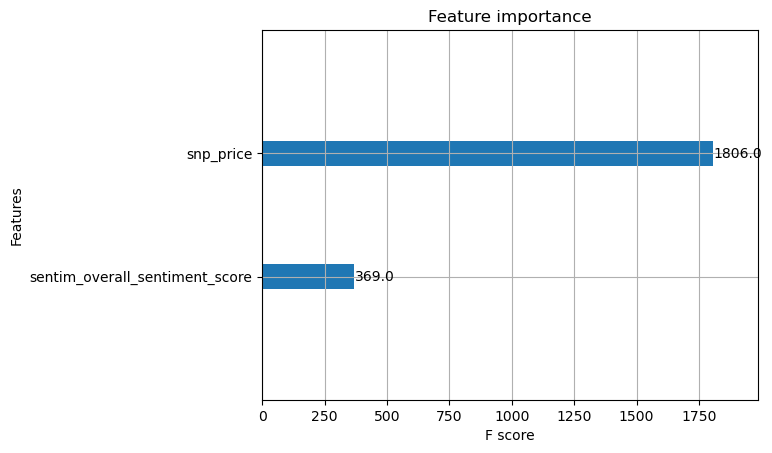

In [134]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(spotify_regr_model, max_num_features=3)
feature_importance_path = images_dir + "/spotify_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

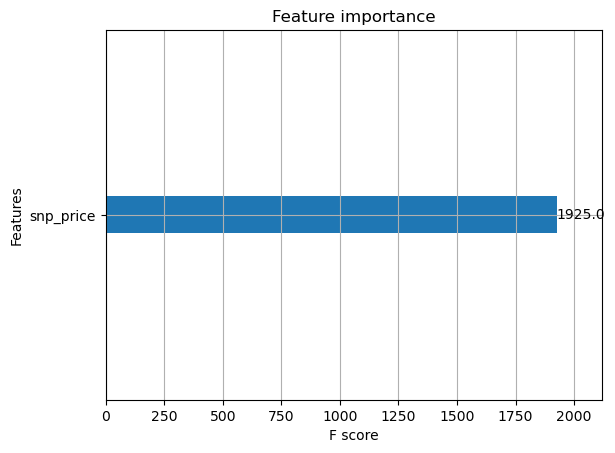

In [135]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(google_regr_model, max_num_features=3)
feature_importance_path = images_dir + "/google_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

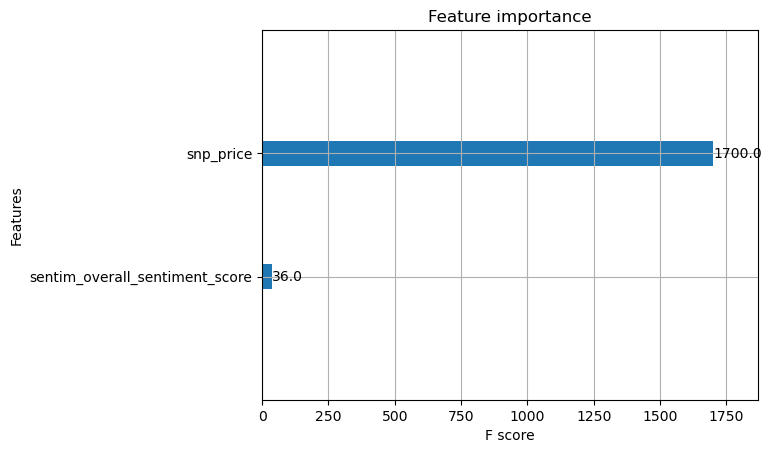

In [136]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(btc_regr_model, max_num_features=3)
feature_importance_path = images_dir + "/bitcoin_feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [160]:
# Spotify
spot_plotting_df = spot_y_test.copy(deep=True)
spot_plotting_df['predicted_price'] = spot_y_pred

# Google
googl_plotting_df = googl_y_test.copy(deep=True)
googl_plotting_df['predicted_price'] = googl_y_pred

# BTC
btc_plotting_df = btc_y_test.copy(deep=True)
btc_plotting_df['predicted_price'] = btc_y_pred

In [161]:
# Spotify
spot_plotting_df['date'] = spot_x_test['timestamp']
spot_plotting_df = spot_plotting_df.sort_values(by=['date'])

# Google
googl_plotting_df['date'] = googl_x_test['timestamp']
googl_plotting_df = googl_plotting_df.sort_values(by=['date'])

# BTC
btc_plotting_df['date'] = btc_x_test['timestamp']
btc_plotting_df = btc_plotting_df.sort_values(by=['date'])


In [171]:
import importlib
from functions import util
importlib.reload(util)

<module 'functions.util' from 'd:\\KTH Assignments\\ID2223 Scalable ML\\project\\StockMarketPrediction\\notebooks\\functions\\util.py'>

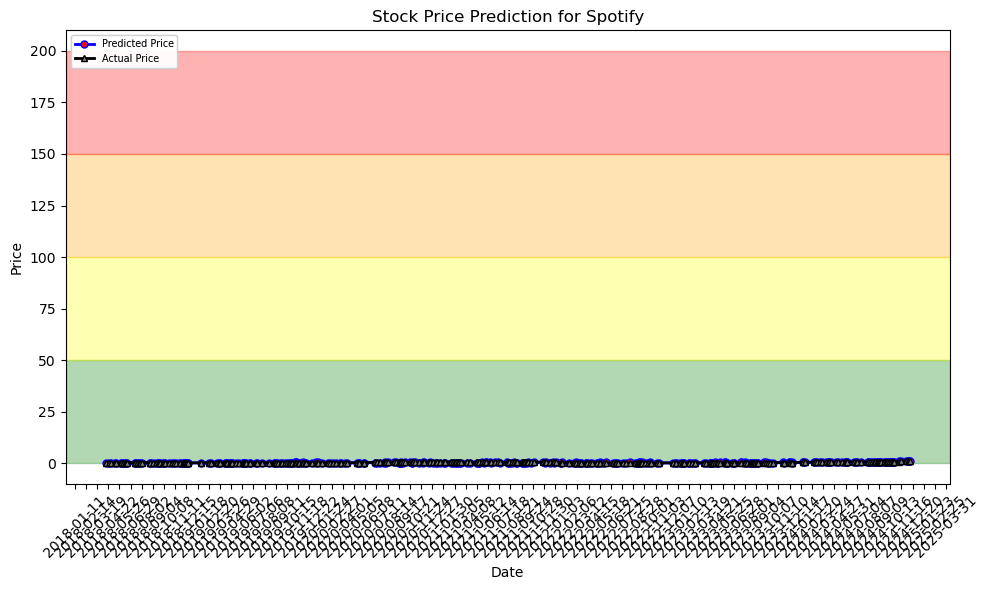

In [172]:
file_path = images_dir + "/stockpred_hindcast.png"
plt = util.plot_stock_price_forecast(df=spot_plotting_df, file_path=file_path, name="Spotify", hindcast=True) 
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [140]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [141]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
spot_input_schema = Schema(spot_train_features)
spot_output_schema = Schema(spot_y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
spot_model_schema = ModelSchema(input_schema=spot_input_schema, output_schema=spot_output_schema)

# Converting the model schema to a dictionary representation
spot_schema_dict = spot_model_schema.to_dict()

In [142]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
googl_input_schema = Schema(googl_train_features)
googl_output_schema = Schema(googl_y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
googl_model_schema = ModelSchema(input_schema=googl_input_schema, output_schema=googl_output_schema)

# Converting the model schema to a dictionary representation
googl_schema_dict = googl_model_schema.to_dict()

In [143]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
btc_input_schema = Schema(btc_train_features)
btc_output_schema = Schema(btc_y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
btc_model_schema = ModelSchema(input_schema=btc_input_schema, output_schema=btc_output_schema)

# Converting the model schema to a dictionary representation
btc_schema_dict = btc_model_schema.to_dict()

In [144]:
# Saving the XGBoost regressor object as a json file in the model directory
spotify_regr_model.save_model(model_dir + "/spotify_model.json")
google_regr_model.save_model(model_dir + "/google_model.json")
btc_regr_model.save_model(model_dir + "/bitcoin_model.json")

In [145]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [146]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'spotify_xgboost_model'

spotify_model = mr.python.create_model(
    name="spotify_xgboost_model", 
    metrics= res_dict,
    model_schema=spot_model_schema,
    input_example=spot_test_features.sample().values, 
    description="Stock Price Predictor for Spotify using XGBoost",
)

# Saving the model artifacts to the 'spotify_model' directory in the model registry
model_file_loc = model_dir + "/spotify_model.json"
spotify_model.save(model_file_loc)

# Creating a Python model in the model registry named 'google_xgboost_model'

google_model = mr.python.create_model(
    name="google_xgboost_model", 
    metrics= {"MSE": str(googl_mse), "R squared": str(googl_r2)},
    model_schema=googl_model_schema,
    input_example=googl_test_features.sample().values, 
    description="Stock Price Predictor for Google using XGBoost",
)

# Saving the model artifacts to the 'google_model' directory in the model registry
model_file_loc = model_dir + "/google_model.json"
google_model.save(model_file_loc)

# Creating a Python model in the model registry named 'bitcoin_xgboost_model'

bitcoin_model = mr.python.create_model(
    name="bitcoin_xgboost_model", 
    metrics= {"MSE": str(btc_mse), "R squared": str(btc_r2)},
    model_schema=btc_model_schema,
    input_example=btc_test_features.sample().values, 
    description="Stock Price Predictor for Bitcoin using XGBoost",
)

# Saving the model artifacts to the 'bitcoin_model' directory in the model registry
model_file_loc = model_dir + "/bitcoin_model.json"
bitcoin_model.save(model_file_loc)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/277975 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/25 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/367 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1205424/models/spotify_xgboost_model/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/255412 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/27 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/367 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1205424/models/google_xgboost_model/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/227981 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/27 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/367 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1205424/models/bitcoin_xgboost_model/1


Model(name: 'bitcoin_xgboost_model', version: 1)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
